# Statistical analysis and visualization of the results from the two methods

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import csv
import seaborn as sns

import statistics

from scipy.stats import wilcoxon
import sklearn
from sklearn.metrics import mean_squared_error

## Initialize some paths and variables

In [2]:
path_parent = os.path.dirname(os.getcwd())
rootdir = os.path.join(path_parent, "results")

subdirs = ["mrcnn_postprocessing", "orcnn_postprocessing"]
labels = ["Mask R-CNN", "ORCNN"]
colors = ["blue", "green"]
palette = {"g", "b"}

image_num = 487
font_size = 11
digit_size = 9

## Store the results in one array

In [3]:
data_combined = np.zeros((image_num*len(subdirs), 11), dtype = object)
counter = 0

for i in range(len(subdirs)):
    subdir = subdirs[i]
    label = labels[i]
    readdir = os.path.join(rootdir, subdir)
    csvfile = "results_" + subdir + ".csv"

    readfile = os.path.join(readdir, csvfile)

    with open(readfile, 'r') as read_obj:
        csv_reader = csv.reader(read_obj)
        next(csv_reader, None)
        for row in csv_reader:
            img_name = row[0]
            amodal_iou = row[1]
            visible_iou = row[2]
            estimated_diameter = row[3]
            real_diameter = row[4]
            diff = row[5]
            ocr = row[6]
            analysis_time = row[7]

            data_combined[counter, 0] = img_name
            data_combined[counter, 1] = float(amodal_iou)
            data_combined[counter, 2] = float(visible_iou)
            data_combined[counter, 3] = float(estimated_diameter)
            data_combined[counter, 4] = float(real_diameter)
            data_combined[counter, 5] = float(diff)
            data_combined[counter, 6] = abs(float(diff))
            data_combined[counter, 7] = round(statistics.ceil_to_decimal(float(ocr)), 1)
            data_combined[counter, 8] = analysis_time
            data_combined[counter, 9] = i
            data_combined[counter, 10] = label
            counter = counter+1

## Initialize a dataframe, which will store the results

In [4]:
df = pd.DataFrame(data=data_combined, columns=["name", "amodal_iou", "visible_iou", "pred_d", "real_d", "diff", "abs_diff", "ocr", "time", "method_id", "method"])
df["abs_diff"] = df["abs_diff"].astype(float)
avg_diff = df.groupby(["method"])["abs_diff"].mean()
max_diff = df.groupby(["method"])["abs_diff"].max()

df["diff"] = df["diff"].astype(float)
diffs = df.groupby(["method"])["diff"].apply(list)
pred_diameters = df.groupby(["method"])["pred_d"].apply(list)
real_diameters = df.groupby(["method"])["real_d"].apply(list)

df["amodal_iou"] = df["amodal_iou"].astype(float)
df["visible_iou"] = df["visible_iou"].astype(float)
df["time"] = df["time"].astype(float)
df["method_id"] = df["method_id"].astype(int)

## Do some summary statistics and plot a histogram

Mask R-CNN


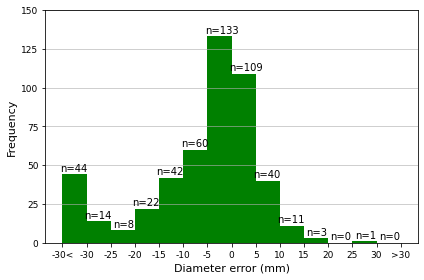

Average absolute diameter error (mm): 10.7
Maximum absolute diameter error (mm): 123.1
Root mean square error of diameter (mm): 18.7

Percentage of errors less than 10 mm (count/total): 70.2\% (342/487)
Percentage of errors less than 20 mm (count/total): 86.2\% (420/487)
Percentage of errors less than 30 mm (count/total): 91.0\% (443/487)
Percentage of errors higher than 30 mm (count/total): 9.0\% (44/487)

ORCNN


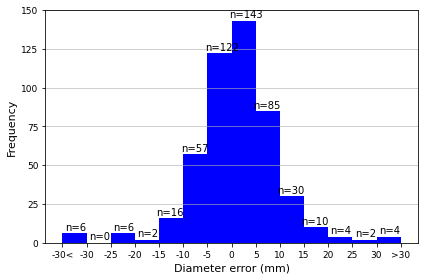

Average absolute diameter error (mm): 6.5
Maximum absolute diameter error (mm): 74.2
Root mean square error of diameter (mm): 9.7

Percentage of errors less than 10 mm (count/total): 83.6\% (407/487)
Percentage of errors less than 20 mm (count/total): 95.5\% (465/487)
Percentage of errors less than 30 mm (count/total): 97.9\% (477/487)
Percentage of errors higher than 30 mm (count/total): 2.1\% (10/487)



In [5]:
colors = colors[::-1]

csv_name = 'summary_stats_diameter_error.csv'
with open(os.path.join(rootdir, csv_name), 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile, delimiter=',',quotechar='|', quoting=csv.QUOTE_MINIMAL)
    csvwriter.writerow(['sumstats', 'mrcnn', 'orcnn'])
    
writelines = ["Average absolute diameter error (mm)", "Maximum absolute diameter error (mm)", 
              "Root mean square error of diameter (mm)", 
              "Percentage of errors less than 10 mm (count/total)",
              "Percentage of errors less than 20 mm (count/total)",
              "Percentage of errors less than 30 mm (count/total)",
              "Percentage of errors higher than 30 mm (count/total)"]

array = np.empty([len(writelines), 3], dtype="U79")

for r in range(len(writelines)):
    writeline = writelines[r]
    array[r, 0] = writeline

              
for i in range(len(labels)):
    label = labels[i]
    print(label)
    subdir = subdirs[i]
    color = colors[i]
    savename = os.path.join(rootdir, "histogram_" + subdir + ".png")
    bins, counts = statistics.histogram_error_fixed_scale(np.asarray(diffs[label]), label, -35, 35, 70, 14, digit_size, font_size, color, savename)

    avg_diff_string = "{0:.1f}".format(avg_diff[label])
    max_diff_string = "{0:.1f}".format(max_diff[label])
    
    print(writelines[0] + ": " + avg_diff_string)
    print(writelines[1] + ": " + max_diff_string)
    
    array[0, i+1] = avg_diff_string
    array[1, i+1] = max_diff_string

    rmse = mean_squared_error(real_diameters[label], pred_diameters[label], squared=False)
    rmse_string = "{0:.1f}".format(rmse)
    print(writelines[2] + ": " + rmse_string)
    array[2, i+1] = rmse_string
    
    print("")
    
    values = [10, 20, 30]
    for j in range(len(values)):
        value = values[j]
        prec, sum_between, sum_all, value = statistics.counts_between(bins, counts, value)
        sum_string = "{0:.1f}\% ({1:.0f}/{2:.0f})".format(prec, sum_between, sum_all, value)
        print(writelines[j+3] + ": " + sum_string)
        array[j+3, i+1] = sum_string

    prec, sum_larger, sum_all, value = statistics.counts_larger(bins, counts, 30)
    sum_string = "{0:.1f}\% ({1:.0f}/{2:.0f})".format(prec, sum_larger, sum_all, value)
    print(writelines[6] + ": " + sum_string)
    array[6, i+1] = sum_string
    
    print("")


for r in range(len(writelines)):
    writeline = array[r]
    with open(os.path.join(rootdir, csv_name), 'a', newline='') as csvfile:
        csvwriter = csv.writer(csvfile, delimiter=',',quotechar='|', quoting=csv.QUOTE_MINIMAL)
        csvwriter.writerow(writeline)

## Plot a combined empirical cumulative distribution function

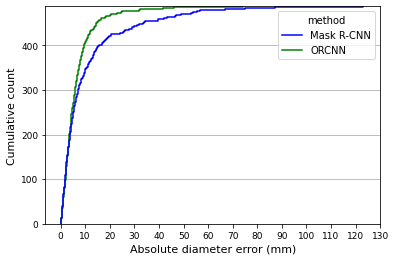

In [6]:
sns.ecdfplot(data=df, x="abs_diff", hue="method", stat="count", palette=palette)

plt.xticks(range(0, 140, 10), fontsize=digit_size)
plt.yticks(fontsize=digit_size)
plt.xlabel("Absolute diameter error (mm)", fontsize=font_size)
plt.ylabel("Cumulative count", fontsize=font_size)
plt.grid(which='major', axis='y', linestyle='-')
# plt.axvline(x=20, ymin=0, ymax=0.965, color='k', linestyle='dotted')
# plt.axhline(xmin=0, xmax=0.2, y=415, color='k', linestyle='dotted')
# plt.axhline(xmin=0, xmax=0.2, y=468, color='k', linestyle='dotted')
plt.savefig(os.path.join(rootdir, 'cumulative_count_diameter_error.png'))
plt.show()

## Store the unique occlusion rates as 10 bins

In [7]:
unique_ocrs = list(set(df["ocr"]))
unique_ocrs.sort()
ocr_counts = np.zeros(len(unique_ocrs)).astype(np.uint8)

x_ticks_list = []

for j in range(len(unique_ocrs)):
    unique_ocr = unique_ocrs[j]
    ocr_count = int(len(np.where(df["ocr"] == unique_ocr)[0])/2)
    ocr_counts[j] = ocr_count

    x_ticks_list.append('{0:.1f}-{1:.1f}'.format(unique_ocr-0.1, unique_ocr))

## Make a combined line-plot of the amodal IoU as a function of the occlusion rate

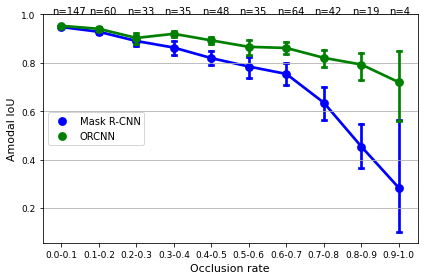

In [8]:
g = sns.pointplot(x="ocr", y="amodal_iou", hue="method", ci=95, palette=palette, data=df, capsize=.1)
g.get_legend().remove()
plt.legend(loc='center left')

for count, x in zip(ocr_counts, unique_ocrs):
    plt.annotate('n={:.0f}'.format(count), ((x*10)-1.25, 1))

plt.xticks(np.arange(len(unique_ocrs)), x_ticks_list, fontsize=digit_size)
plt.xlabel("Occlusion rate", fontsize=font_size)

plt.yticks(fontsize=digit_size)
plt.ylabel("Amodal IoU", fontsize=11)
plt.grid(which='major', axis='y', linestyle='-')

plt.tight_layout()
plt.savefig(os.path.join(rootdir, 'amodal_IoU_occlusion_rate.png'))
plt.show()

## Make a combined line-plot of the visible IoU as a function of the occlusion rate

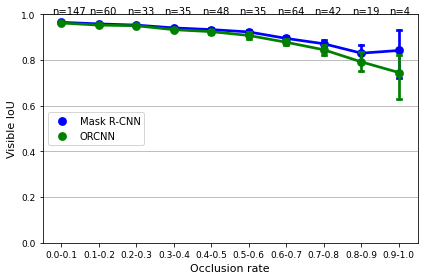

In [9]:
g = sns.pointplot(x="ocr", y="visible_iou", hue="method", ci=95, palette=palette, data=df, capsize=.1)
g.get_legend().remove()
plt.legend(loc='center left')

for count, x in zip(ocr_counts, unique_ocrs):
    plt.annotate('n={:.0f}'.format(count), ((x*10)-1.25, 1))

plt.xticks(np.arange(len(unique_ocrs)), x_ticks_list, fontsize=digit_size)
plt.xlabel("Occlusion rate", fontsize=font_size)

plt.yticks(np.arange(0, 1.2, 0.2), fontsize=digit_size)
plt.ylabel("Visible IoU", fontsize=11)
plt.grid(which='major', axis='y', linestyle='-')

plt.tight_layout()
plt.savefig(os.path.join(rootdir, 'visible_IoU_occlusion_rate.png'))
plt.show()

## Make a combined line-plot of the diameter error as a function of the occlusion rate

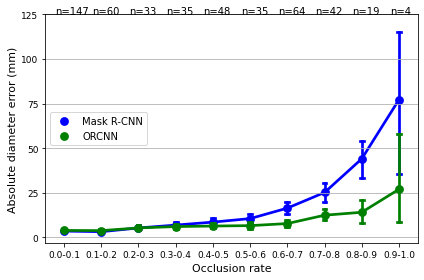

In [10]:
bin_step = 25
max_val = statistics.ceil_to_25(np.max(df["abs_diff"]))

g = sns.pointplot(x="ocr", y="abs_diff", hue="method", ci=95, palette=palette, data=df, capsize=.1)
g.get_legend().remove()
plt.legend(loc='center left')

for count, x in zip(ocr_counts, unique_ocrs):
    plt.annotate('n={:.0f}'.format(count), ((x*10)-1.25, 125))

plt.xticks(np.arange(len(unique_ocrs)), x_ticks_list, fontsize=digit_size)
plt.xlabel("Occlusion rate", fontsize=font_size)

plt.yticks(range(0, int(max_val) + bin_step, bin_step), fontsize=digit_size)
plt.ylabel("Absolute diameter error (mm)", fontsize=11)
plt.grid(which='major', axis='y', linestyle='-')

plt.tight_layout()
plt.savefig(os.path.join(rootdir, 'diameter_error_occlusion_rate.png'))
plt.show()

## Make a dual y-axis line-plot of the diameter error and the amodal IoU as a function of the occlusion rate

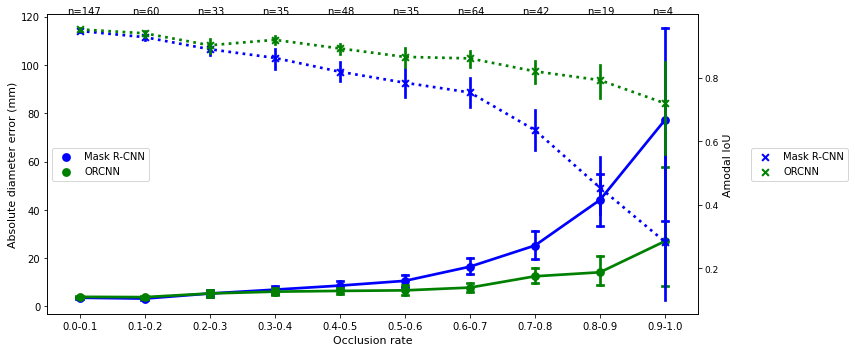

In [11]:
fig, ax1 = plt.subplots(figsize=(12, 5))
g1 = sns.pointplot(x="ocr", y="abs_diff", hue="method", ci=95, palette=palette, data=df, ax=ax1, capsize=.1)
g1.get_legend().remove()
ax1.set_xlabel("Occlusion rate", fontsize=font_size)
ax1.set_ylabel("Absolute diameter error (mm)", fontsize=font_size)
ax1.legend(loc='center left')

ax2 = ax1.twinx()
g2 = sns.pointplot(x="ocr", y="amodal_iou", hue="method", ci=95, palette=palette, data=df, ax=ax2, markers=["x", "x", "x"], linestyles=[":", ":", ":"])
g2.get_legend().remove()
ax2.set_ylabel("Amodal IoU", fontsize=font_size)
ax2.legend(loc='center left', bbox_to_anchor=(1.075, 0.5))

for count, x in zip(ocr_counts, unique_ocrs):
    plt.annotate('n={:.0f}'.format(count), ((x*10)-1.2, 1))

plt.xticks(np.arange(len(unique_ocrs)), x_ticks_list, fontsize=digit_size)
plt.yticks(fontsize=digit_size)

plt.tight_layout()
plt.show()

## Boxplot with the inference times for all methods

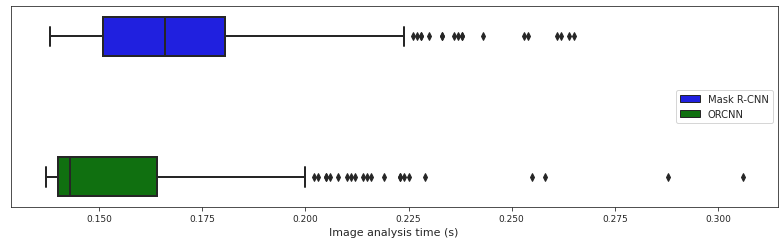

In [12]:
sns.set_style("ticks")
f, ax = plt.subplots(figsize=(11, 3.5))

ax = sns.boxplot(x="time", y="method_id", hue="method", orient="h", palette=palette, linewidth=2, data=df)
ax.set_ylabel('')
plt.legend(loc='center right')

plt.xlabel('Image analysis time (s)', fontsize=font_size)
plt.xticks(fontsize=digit_size)
plt.yticks([])

# plt.title("Image analysis time when sizing {0:.0f} broccoli heads".format(image_num), fontsize=font_size)

plt.tight_layout()
plt.savefig(os.path.join(rootdir, 'image_analysis_times.png'))
plt.show()

## Wilcoxon Signed-Rank Test of amodal IoU for each occlusion rate

In [13]:
## thanks to: https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/
csv_name = 'wilcoxon_amodal_IoU.csv'
with open(os.path.join(rootdir, csv_name), 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile, delimiter=',',quotechar='|', quoting=csv.QUOTE_MINIMAL)
    csvwriter.writerow(['ocr', 'mrcnn', 'orcnn', 'p'])

iou = df.groupby(["name", "ocr", "method"])["amodal_iou"].apply(list)
ocr = df.groupby(["name"])["ocr"].apply(list)

ids1 = np.arange(0, len(iou), 2)
ids2 = np.arange(1, len(iou), 2)

iou_mp = np.zeros(len(ids1)).astype(np.float32)
iou_op = np.zeros(len(ids2)).astype(np.float32)

ocrs = np.zeros(len(ids1)).astype(np.float32)

for i in range(len(iou)):
    if i in ids1:
        idx = int(i/2)
        iou_mp[idx] = iou[i][0]
        ocrs[idx] = ocr[idx][0]
    if i in ids2:
        idx = int((i-1)/2)
        iou_op[idx] = iou[i][0]
        
alpha = 0.05
print("{:<25} {:<51} {:<25}".format('', 'AVG (STD) of Amodal Intersection over Union', 'P-value Wilcoxon'))
print("{:<25} {:<25} {:<25} {:<25}".format('Occlusion rate', 'MP', 'OP', 'MP-OP'))

for j in range(len(unique_ocrs)):
    unique_ocr = unique_ocrs[j]    
    idxs = np.where(ocrs == unique_ocr)[0]
    
    m_p = []
    o_p = []
    
    for k in range(len(idxs)):
        idx = idxs[k]
        m_p.append(iou_mp[idx])
        o_p.append(iou_op[idx])
        
    stat, p_mp_op = wilcoxon(m_p, o_p)
    
    if p_mp_op > 0.05:
        sign = "ns"
    elif 0.01 < p_mp_op <= 0.05:
        sign = "*"
    elif 0.001 < p_mp_op <= 0.01:
        sign = "**"
    elif 0.0001 < p_mp_op <= 0.001:
        sign = "***"
    elif p_mp_op <= 0.0001:
        sign = "****"
    
    ocr_string = '{0:.1f}-{1:.1f}'.format(unique_ocr-0.1, unique_ocr)
    avgstd_mp = '{0:.2f} ({1:.2f})'.format(np.average(m_p), np.std(m_p))
    avgstd_op = '{0:.2f} ({1:.2f})'.format(np.average(o_p), np.std(o_p))

    if j != (len(unique_ocrs)-1):
        p_mp_op = '{0:.2f} ({1})'.format(p_mp_op, sign)
    else:
        p_mp_op = '-'

    print("{:<25} {:<25} {:<25} {:<25}".format(ocr_string, avgstd_mp, avgstd_op, p_mp_op))
    
    with open(os.path.join(rootdir, csv_name), 'a', newline='') as csvfile:
        csvwriter = csv.writer(csvfile, delimiter=',',quotechar='|', quoting=csv.QUOTE_MINIMAL)
        csvwriter.writerow([ocr_string, avgstd_mp, avgstd_op, p_mp_op])

    
print("")
print("Explanation:")
print("MP : Mask R-CNN & Post-processing")
print("OP : ORCNN & Post-processing")
print("")
print("MP-OP : rank comparison between Mask R-CNN & Post-processing and ORCNN & Post-processing")
print("")
print("- : sample size too small for normal approximation")
print("")
print("The P-values lower than 0.05 indicate that the tested distributions are significantly different")

                          AVG (STD) of Amodal Intersection over Union         P-value Wilcoxon         
Occlusion rate            MP                        OP                        MP-OP                    
0.0-0.1                   0.95 (0.03)               0.95 (0.03)               0.00 (**)                
0.1-0.2                   0.93 (0.04)               0.94 (0.04)               0.00 (***)               
0.2-0.3                   0.89 (0.06)               0.90 (0.07)               0.17 (ns)                
0.3-0.4                   0.86 (0.09)               0.92 (0.04)               0.00 (**)                
0.4-0.5                   0.82 (0.11)               0.89 (0.06)               0.00 (****)              
0.5-0.6                   0.78 (0.13)               0.87 (0.09)               0.00 (**)                
0.6-0.7                   0.75 (0.18)               0.86 (0.11)               0.00 (****)              
0.7-0.8                   0.64 (0.22)               0.82 (0.12) 

## Wilcoxon Signed-Rank Test of diameter error for each occlusion rate

In [14]:
## thanks to: https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/
csv_name = 'wilcoxon_diameter_error.csv'
with open(os.path.join(rootdir, csv_name), 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile, delimiter=',',quotechar='|', quoting=csv.QUOTE_MINIMAL)
    csvwriter.writerow(['ocr', 'mrcnn', 'orcnn', 'p'])

abs_diff = df.groupby(["name", "ocr", "method"])["abs_diff"].apply(list)
ocr = df.groupby(["name"])["ocr"].apply(list)

ids1 = np.arange(0, len(abs_diff), 2)
ids2 = np.arange(1, len(abs_diff), 2)

abs_diff_mp = np.zeros(len(ids1)).astype(np.float32)
abs_diff_op = np.zeros(len(ids2)).astype(np.float32)

ocrs = np.zeros(len(ids1)).astype(np.float32)

for i in range(len(abs_diff)):
    if i in ids1:
        idx = int(i/2)
        abs_diff_mp[idx] = abs_diff[i][0]
        ocrs[idx] = ocr[idx][0]
    if i in ids2:
        idx = int((i-1)/2)
        abs_diff_op[idx] = abs_diff[i][0]
        
        
alpha = 0.05
print("{:<25} {:<51} {:<25}".format('', 'AVG (STD) of absolute diameter error (mm)', 'P-value Wilcoxon'))
print("{:<25} {:<25} {:<25} {:<25}".format('Occlusion rate', 'MP', 'OP', 'MP-OP'))

for j in range(len(unique_ocrs)):
    unique_ocr = unique_ocrs[j]    
    idxs = np.where(ocrs == unique_ocr)[0]
    
    m_p = []
    o_p = []
    
    for k in range(len(idxs)):
        idx = idxs[k]
        m_p.append(abs_diff_mp[idx])
        o_p.append(abs_diff_op[idx])
        
    stat, p_mp_op = wilcoxon(m_p, o_p)
    
    if p_mp_op > 0.05:
        sign = "ns"
    elif 0.01 < p_mp_op <= 0.05:
        sign = "*"
    elif 0.001 < p_mp_op <= 0.01:
        sign = "**"
    elif 0.0001 < p_mp_op <= 0.001:
        sign = "***"
    elif p_mp_op <= 0.0001:
        sign = "****"
    
    ocr_string = '{0:.1f}-{1:.1f}'.format(unique_ocr-0.1, unique_ocr)
    avgstd_mp = '{0:.1f} ({1:.1f})'.format(np.average(m_p), np.std(m_p))
    avgstd_op = '{0:.1f} ({1:.1f})'.format(np.average(o_p), np.std(o_p))

    if j != (len(unique_ocrs)-1):
        p_mp_op = '{0:.2f} ({1})'.format(p_mp_op, sign)
    else:
        p_mp_op = '-'

    print("{:<25} {:<25} {:<25} {:<25}".format(ocr_string, avgstd_mp, avgstd_op, p_mp_op))
    
    with open(os.path.join(rootdir, csv_name), 'a', newline='') as csvfile:
        csvwriter = csv.writer(csvfile, delimiter=',',quotechar='|', quoting=csv.QUOTE_MINIMAL)
        csvwriter.writerow([ocr_string, avgstd_mp, avgstd_op, p_mp_op])
    
print("")
print("Explanation:")
print("MP : Mask R-CNN & Post-processing")
print("OP : ORCNN & Post-processing")
print("")
print("MP-OP : rank comparison between Mask R-CNN & Post-processing and ORCNN & Post-processing")
print("")
print("- : sample size too small for normal approximation")
print("")
print("The P-values lower than 0.05 indicate that the tested distributions are significantly different")

                          AVG (STD) of absolute diameter error (mm)           P-value Wilcoxon         
Occlusion rate            MP                        OP                        MP-OP                    
0.0-0.1                   3.6 (3.1)                 4.0 (2.9)                 0.10 (ns)                
0.1-0.2                   3.2 (2.6)                 3.9 (2.4)                 0.06 (ns)                
0.2-0.3                   5.3 (4.1)                 5.4 (4.0)                 0.64 (ns)                
0.3-0.4                   7.0 (4.8)                 6.1 (4.5)                 0.39 (ns)                
0.4-0.5                   8.6 (7.0)                 6.4 (4.7)                 0.09 (ns)                
0.5-0.6                   10.6 (7.8)                6.6 (6.0)                 0.02 (*)                 
0.6-0.7                   16.5 (13.6)               7.8 (7.8)                 0.00 (****)              
0.7-0.8                   25.2 (18.4)               12.5 (10.2) 